# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

In [1]:
#pip install shap

In [2]:
#pip install catboost

### Установка библиотек и настройка окружения

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
import shap

from IPython.display import display

from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

import scipy
import scipy.stats as stats
from scipy.stats import poisson

import phik
from phik import resources, report

warnings.filterwarnings('ignore')

c:\Users\eprutskoy\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\eprutskoy\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format

### Инициализация полезных функций

In [5]:
class DatasetSizeTracker:
    def __init__(self):
        self.initial_size = None
        self.previous_size = None

    def track(self, data):
        # Если исходный размер не был установлен, запоминаем его и текущий размер как первоначальный
        if self.initial_size is None:
            self.initial_size = len(data)
            self.previous_size = len(data)
            loss_from_initial = 0
            loss_from_previous = 0
            loss_percent_overoll = 0
        else:
            # Считаем, сколько строк потеряно относительно исходного размера и с прошлого вызова
            current_size = len(data)
            loss_from_initial = self.initial_size - current_size
            loss_from_previous = self.previous_size - current_size
            loss_percent_overoll = ((self.initial_size - current_size)/self.initial_size)*100
            # Обновляем предыдущий размер для следующего вызова
            self.previous_size = current_size
        
        return {"Потери от исходного размера": loss_from_initial, "Потери с предыдущего раза": loss_from_previous,
                'Общие потери в процентах' : loss_percent_overoll}

# Создание экземпляра класса для трекинга размера датасета
tracker = DatasetSizeTracker()

In [6]:
# функция информации по таблице
def dataframe_summary(df, string):
    # Вывод общей информации
    print("Общая информация по таблице:", string)
    df.info()

    # Вывод статистического описания
    print("\n Статистическое описание:")
    display(df.describe().transpose())

    # Вывод случайных примеров
    print("\nСлучайные примеры:")
    display(df.sample(5))

    # Вывод количества строк и столбцов
    print("\nКоличество строк и столбцов:", df.shape)
    
    # Вывод количества явных дубликатов
    print("\nКоличество явных дубликатов:", df.duplicated().sum())
    print('')

In [7]:
# функция поиска пропусков
def analyze_missing_values(df, string):
        total = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data.query('Total > 0')

        # Вывод информации о пропусках
        print(f"Пропуски в датафрейме {string}:\n{missing_data}\n")

        # Создание и отображение тепловой карты
        plt.figure(figsize=(12, 8))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
        plt.title(f"Heatmap пропусков для {string}")
        plt.show()

In [8]:
# Функция для преобразования названий в змеиный регистр (snake_case) 
def to_snake_case(name): 
    s1 = name[0].lower() 
    for c in name[1:]: 
        if c.isupper(): 
            s1 += '_' 
            s1 += c.lower() 
        else: 
            s1 += c 
    return s1 
 

### Обзор данных, работа с дубликатами, пропусками и выбросами

План работы:
1) Анализ описательной статитстики по данным;
2) Очистка явных дубликатов;
3) Обработка пропусков;
4) Обработка выбросов;
5) Анализ визуальной статистики.

#### Обзор данных

In [9]:
data = pd.read_csv('autos.csv')

# Создадим отдельный датасет, который мы оставим в исходном состоянии. 
# Все необходимые преобразования
# data_model = data.copy()

In [10]:
dataframe_summary(data, 'Автомобили (data)')

Общая информация по таблице: Автомобили (data)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           35

,count,mean,std,min,25%,50%,75%,max
Price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
RegistrationYear,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
Kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
RegistrationMonth,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,"354,369.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,"354,369.00","50,508.69","25,783.10","1,067.00","30,165.00","49,413.00","71,083.00","99,998.00"



Случайные примеры:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
115109,2016-03-18 15:52:06,800,coupe,1993,NaN,0,other,150000,3,petrol,ford,NaN,2016-03-18 00:00:00,0,33330,2016-04-05 22:18:12
110003,2016-03-24 20:46:29,13999,sedan,2013,manual,105,leon,50000,8,gasoline,seat,no,2016-03-24 00:00:00,0,94154,2016-04-05 13:45:26
223989,2016-04-03 22:53:34,300,sedan,1994,manual,174,100,150000,2,petrol,audi,yes,2016-04-03 00:00:00,0,94034,2016-04-06 00:45:10
13816,2016-03-30 18:42:00,3450,small,2005,auto,68,aygo,150000,10,petrol,toyota,no,2016-03-30 00:00:00,0,22927,2016-04-07 09:45:04
130189,2016-03-21 18:56:09,950,small,1999,manual,55,seicento,150000,3,petrol,fiat,no,2016-03-21 00:00:00,0,48493,2016-03-24 08:44:44



Количество строк и столбцов: (354369, 16)

Количество явных дубликатов: 4



In [11]:
tracker = DatasetSizeTracker()

tracker.track(data)  # Посмотреть, сколько строк потеряно с исходного момента и с последнего вызова

{'Потери от исходного размера': 0,
 'Потери с предыдущего раза': 0,
 'Общие потери в процентах': 0}

Изменим названия переменных, избавимся от дубликатов

In [12]:
data.columns = [to_snake_case(name) for name in data.columns] 
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [13]:
# удалим явные дубликаты
data.drop_duplicates(inplace=True)

В данных есть объявления с ценой равной 0. Тк это целевой признак - менять нельзя, но лучше удалить строки с такой ценой.

In [14]:
print('Сколько людей готовы "подарить" автомобиль:',len(data.loc[data['price'] == 0]))
data = data.loc[data['price'] != 0]
print('Сколько людей готовы "подарить" автомобиль теперь:',len(data.loc[data['price'] == 0]))

Сколько людей готовы "подарить" автомобиль: 10772
Сколько людей готовы "подарить" автомобиль теперь: 0


In [15]:
tracker.track(data) 

{'Потери от исходного размера': 10776,
 'Потери с предыдущего раза': 10776,
 'Общие потери в процентах': 3.0408980469510594}

Пропуски в датафрейме data:
              Total  Percent
repaired      65866    19.17
vehicle_type  33750     9.82
fuel_type     29459     8.57
model         17521     5.10
gearbox       17355     5.05



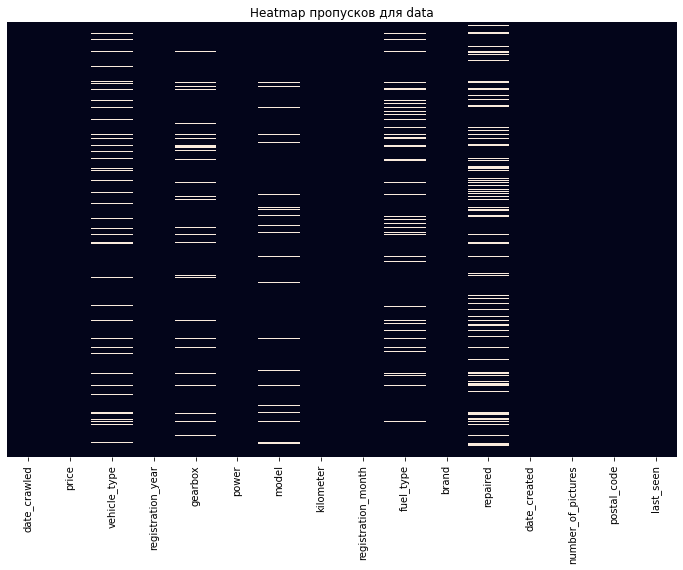

In [16]:
analyze_missing_values(data, 'data')

Избавимся от явных дубликатов, возможно, после обработки датасета и удаления ненужных переменных дубликатов станет больше.

In [17]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis =1) 

In [18]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [19]:
display(data[['brand', 'model','vehicle_type', 'fuel_type', 'gearbox', 'power' ,'repaired','price']].sample(10))

,brand,model,vehicle_type,fuel_type,gearbox,power,repaired,price
158277,ford,fiesta,small,petrol,manual,60,no,1790
196904,opel,corsa,small,petrol,manual,90,no,299
276855,mercedes_benz,clk,convertible,petrol,auto,163,no,16799
17916,suzuki,other,small,petrol,manual,60,no,500
158411,renault,clio,NaN,petrol,manual,70,no,580
347343,seat,altea,bus,gasoline,manual,105,no,3999
25892,opel,astra,sedan,petrol,manual,101,no,750
182132,volkswagen,transporter,bus,gasoline,manual,110,no,4700
53297,bmw,3er,sedan,petrol,manual,102,no,1500
60868,audi,a6,wagon,gasoline,auto,179,no,4550


#### Работа с пропусками

##### Пропуски в `model`

Пропуски в `model`, на мой взгляд, критичны. Фактор модели может играть значительную роль в определении цены машины. Восполнить пропуски здесь никак, заглушка тоже может в данном случае не подойти или нарушить связи. 

In [20]:
data = data.loc[~data['model'].isna()]
tracker.track(data) 

{'Потери от исходного размера': 28297,
 'Потери с предыдущего раза': 17521,
 'Общие потери в процентах': 7.985179290513561}

##### Пропуски в `repaired`

Пропусков в repaired довольно много, порядка 20% от изначального размера данных.\
Фактор довольно важный, при написании объявления обязательно указывать, если машина ремонтировалась. Возможно, значения в этом столбце пропущены, если машина не чинилась и продавцы оставляли незаполненным этот пропуск. \
Если качество модели будет неудовлетворительным, можно попробовать применить заглушку.


In [21]:
data.repaired.value_counts()

repaired
no     235821
yes     31958
Name: count, dtype: int64

In [22]:
data.repaired.fillna('no', inplace=True)

Пропуски в датафрейме data:
              Total  Percent
vehicle_type  28166     8.64
fuel_type     23551     7.22
gearbox       14270     4.38



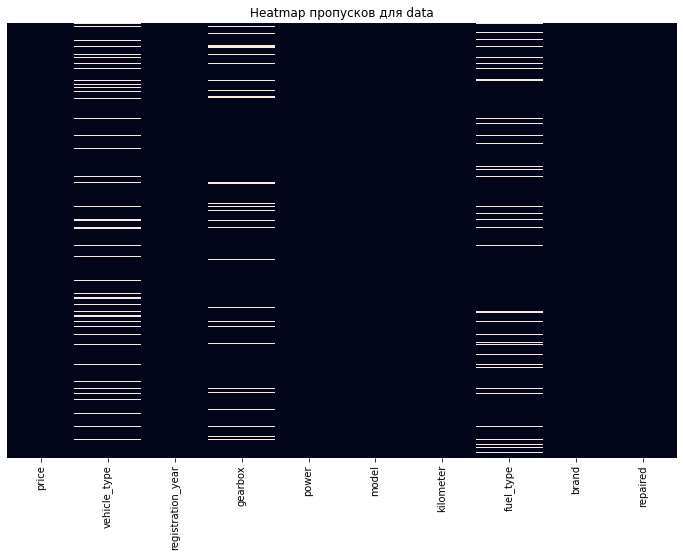

In [23]:
analyze_missing_values(data, 'data')

Остались пропуски в `vehicle_type`,  `fuel_type` и `gearbox` - их заполним на основе данных из `model` и `brand`

In [25]:
print(data['vehicle_type'].unique())
print(data['fuel_type'].unique())
print(data['gearbox'].unique())

[nan 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
['manual' 'auto' nan]


## Обучение моделей

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей